In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os 
from glob import glob
import tqdm
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import math
from tensorflow.keras import backend as K

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

# 내가 사용할 GPU번호(0,1,2,3)
os.environ["CUDA_VISIBLE_DEVICES"]="1"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus: 
    try: # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus: 
            tf.config.experimental.set_memory_growth(gpu, True)
             
        logical_gpus = tf.config.experimental.list_logical_devices('GPU') 
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs") 
    
    except RuntimeError as e: # Memory growth must be set before GPUs have been initialized 
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
os.chdir('/tf/notebooks/data/bone/')
train_csv = pd.read_csv('256train.csv')
test_csv = pd.read_csv('256test2300.csv')
testset_csv = pd.read_csv('256testset.csv')

print(train_csv.head())
print(test_csv.head())
print(testset_csv.head())

   img_id   input_img label_img
0     NaN  input1.npy     1.npy
1     NaN  input2.npy     2.npy
2     NaN  input3.npy     3.npy
3     NaN  input4.npy     4.npy
4     NaN  input5.npy     5.npy
  test_img
0    1.npy
1    2.npy
2    3.npy
3    4.npy
4    5.npy
  input_img
0     1.npy
1     2.npy
2     3.npy
3     4.npy
4     5.npy


In [4]:
train_all_input_files = '256input/'+train_csv['input_img']
train_all_label_files = '256label/'+train_csv['label_img']
test_all_input_files = 'unet2300/'+test_csv['test_img']
# test_all_test_files = 'unet362/'+test_csv['input_img']
# test_all_test_files = test_all_test_files[:362]

print(len(train_all_input_files), len(train_all_label_files), len(test_all_input_files)) #len(test_all_test_files)

271 271 2300


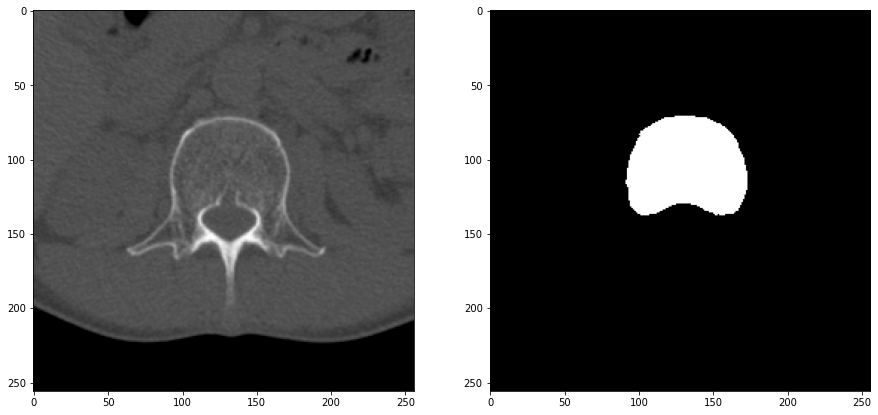

(256, 256, 1)
(256, 256, 1)


In [5]:
train_input_files = train_all_input_files[55:]
train_label_files = train_all_label_files[55:]

val_input_files = train_all_input_files[:55]
val_label_files = train_all_label_files[:55]

test_input_files = test_all_input_files[:]
# test_test_files = test_all_test_files[:]

for input_path, label_path in zip(train_input_files, train_label_files):
    inp_img = np.load(input_path)
    targ_img = np.load(label_path)
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(inp_img, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(targ_img, cmap='gray')
    plt.show()
    print(inp_img.shape)
    print(targ_img.shape)
    break

In [6]:
BATCH_SIZE = 8
img_size = 256
weights = None
learning_rate = 1e-5
EPOCHS = 500
dropout_rate = 0.1

In [7]:
def prep_img(img_path_list, save_path):
    os.makedirs(f'{save_path}{img_size}', exist_ok=True)
    num = 0
    for path in tqdm(img_path_list):
        rawimg = np.load(path)
        clipimg = np.clip(rawimg, -160,240) #window level(spine)
        img = (clipimg-np.min(clipimg))/(np.max(clipimg)-np.min(clipimg)) #normalize
        np.save(f'{save_path}{img_size}/{num}.npy', img)
        num+=1

In [10]:
# prep_img(train_input_files, 'data3/train_input_img_', 256)
# prep_img(train_label_files, 'data3/train_label_img_', 256)
# prep_img(val_input_files, 'data3/val_input_img_', 256)
# prep_img(val_label_files, 'data3/val_label_img_', 256)

100%|██████████| 55/55 [00:00<00:00, 348.32it/s]


In [8]:
train_inp_files = glob(f'./data3/train_input_img_{img_size}/*.npy')
train_targ_files = glob(f'./data3/train_label_img_{img_size}/*.npy')

val_inp_files = glob(f'./data3/val_input_img_{img_size}/*.npy')
val_targ_files = glob(f'./data3/val_label_img_{img_size}/*.npy')

In [9]:
train_inp_files, train_targ_files = shuffle(train_inp_files, train_targ_files, random_state=42)
len(train_inp_files), len(val_inp_files), len(train_targ_files), len(val_targ_files)

(216, 55, 216, 55)

In [10]:
def train_map_func(inp_path, targ_path):
    inp = np.load(inp_path)
    inp = inp.astype(np.float32)
    targ = np.load(targ_path)
    targ = targ.astype(np.float32)
    inp, targ = augmentation(inp, targ)
    
    return inp, targ

def val_map_func(inp_path, targ_path):
    inp = np.load(inp_path)
    inp = inp.astype(np.float32)
    targ = np.load(targ_path)
    targ = targ.astype(np.float32)
    return inp, targ

def augmentation(inp, targ):
    inp, targ = random_rot(inp, targ)
    inp, targ = random_flip(inp, targ)
    
    return inp, targ

def random_rot(inp, targ):
    k = np.random.randint(4)
    inp = np.rot90(inp, k)
    targ = np.rot90(targ, k)
    
    return inp, targ

def random_flip(inp, targ):
    f = np.random.randint(2)
    if f == 0:
        inp = np.fliplr(inp)
        targ = np.fliplr(targ)
        
    return inp, targ

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_inp_files, train_targ_files))
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(train_map_func, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_inp_files, val_targ_files))
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(val_map_func, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [12]:
print(next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape, next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape)

(8, 256, 256, 1) (8, 256, 256, 1) (8, 256, 256, 1) (8, 256, 256, 1)


In [13]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = tf.keras.layers.Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if activation == True:
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(blockInput)
    x = tf.keras.layers.BatchNormalization()(x)
    blockInput = tf.keras.layers.BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = tf.keras.layers.Add()([x, blockInput])
    return x

In [14]:
def unet_resbone(input_shape=(None, None, 1), dropout_rate=0.1, start_neurons = 16):
    backbone = tf.keras.applications.ResNet101V2(weights=weights, include_top=False, input_shape=input_shape)
    input_layer = backbone.input
    
    conv4 = backbone.layers[122].output
    conv4 = tf.keras.layers.LeakyReLU(alpha=0.1)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
    pool4 = tf.keras.layers.Dropout(dropout_rate)(pool4)
    
    convm = tf.keras.layers.Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = tf.keras.layers.LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = tf.keras.layers.Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = tf.keras.layers.concatenate([deconv4, conv4])
    uconv4 = tf.keras.layers.Dropout(dropout_rate)(uconv4)
    
    uconv4 = tf.keras.layers.Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv4)
    
    deconv3 = tf.keras.layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[76].output
    uconv3 = tf.keras.layers.concatenate([deconv3, conv3])    
    uconv3 = tf.keras.layers.Dropout(dropout_rate)(uconv3)
    
    uconv3 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = tf.keras.layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[30].output
    uconv2 = tf.keras.layers.concatenate([deconv2, conv2])
        
    uconv2 = tf.keras.layers.Dropout(0.1)(uconv2)
    uconv2 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = tf.keras.layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[2].output
    uconv1 = tf.keras.layers.concatenate([deconv1, conv1])
    
    uconv1 = tf.keras.layers.Dropout(0.1)(uconv1)
    uconv1 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = tf.keras.layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = tf.keras.layers.Dropout(0.1)(uconv0)
    uconv0 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = tf.keras.layers.Dropout(dropout_rate/2)(uconv0)
    output_layer = tf.keras.layers.Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = tf.keras.models.Model(input_layer, output_layer)
    
    return model

In [15]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate)
model = unet_resbone(input_shape=(img_size, img_size, 1),dropout_rate=dropout_rate)
model.compile(loss=dice_coef_loss, optimizer=optimizer)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [26]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='unet_ns.png', show_shapes=True, show_layer_names=True)

In [22]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = 'models/model_full_dice500.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )
]

In [ ]:
# hist = model.fit(train_dataset, epochs=500, validation_data=val_dataset, callbacks=callbacks_list)